# Slow-fast dynamics and bursting

In this notebook, we explore the dynamics of a single compartment neuron model developed to study how persistent Na+ and M-type K+ currents contribute to bursting in a model of CA1 pyramidal cell.

The model and all parameters are taken from [this paper](https://journals.physiology.org/doi/epdf/10.1152/jn.00205.2006).

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns

#### The constant parameters of the model

i.e., those that do not vary when burst generation is studied:

In [2]:
Cm = 1

ENa,ECa,EK,EL = 55, 120, -90, -70

gL = 0.05
gNafbar = 35
gKdrbar = 6
gKAHPbar = 5
gAbar = 1.4
gMbar = 1

taub,tauz,taur,tauq = 15, 75, 1, 450
tauCa = 13
tauKc = 2

thetam,sigmam = -30, 9.5
thetah,sigmah = -45, -7
thetan,sigman = -35, 10
thetaa,sigmaa = -50, 20
thetab,sigmab = -80, -6
thetac,sigmac = -30, 7
thetar,sigmar = -20, 10
thetaz,sigmaz = -39, 5
thetap,sigmap = -41, 3

t_tauh,t_taun = -40.5, -27
phi = 10
uuCa = 0.13

Here we define the functions that make up the vector field of the model:

In [3]:
GAMMAF = lambda VV,theta,sigma: 1.0 / (1.0+np.exp(-(VV-theta)/sigma))
ZFUNC = lambda aa,ca,z: 1 / (1+(aa**z/ca**z))

def func(t,x,I):
    v,h,n,b,z,r,c,q,ca = x
    Minfs = GAMMAF(v,thetam,sigmam)
    Pinfs = GAMMAF(v,thetap,sigmap)
    Ainfs = GAMMAF(v,thetaa,sigmaa)
    mKCa = ZFUNC(6,ca,1)
    INa = gNafbar*Minfs**3*h*(v-ENa)
    INaP = gNapbar*Pinfs*(v-ENa)
    IKdr = gKdrbar*n**4*(v-EK)
    IA = gAbar*Ainfs**3*b*(v-EK)
    IM = gMbar*z*(v-EK)
    ICa = gCabar*r**2*(v-ECa)
    IKC = gKCabar*mKCa*c*(v-EK)
    IAHP = gKAHPbar*q*(v-EK) 
    return np.array([
        (-gL*(v-EL)-INa-INaP-IKdr-IA-IM-ICa-IKC-IAHP+I)/Cm,
        phi*(GAMMAF(v,thetah,sigmah)-h)/(1.0+7.5*GAMMAF(v,t_tauh,-6.0)),
        phi*(GAMMAF(v,thetan,sigman)-n)/(1.0+5.0*GAMMAF(v,t_taun,-15.0)),
        (GAMMAF(v,thetab,sigmab)-b)/taub,
        (GAMMAF(v,thetaz,sigmaz)-z)/tauz,
        (GAMMAF(v,thetar,sigmar)-r)/taur,
        (GAMMAF(v,thetac,sigmac)-c)/tauKc,
        (ZFUNC(2,ca,4)-q)/tauq,
        -uuCa*ICa-ca/tauCa
    ])

Select the extracellular calcium concentration:

In [4]:
zero_calcium = True
if zero_calcium:
    gNapbar = 0.3
    gCabar = 0
    gKCabar = 0
    thetap = -47
    Iapp = 0.66
else:
    gNapbar = 0.2
    gCabar = 0.08
    gKCabar = 10
    thetap = -41
    Iapp = 1

The initial conditions for the integration:

In [5]:
V0 = -71.962
h0 = 0.979199
n0 = 0.0242166
b0 = 0.207565
z0 = 0.0013689
r0 = 0.005507
c0 = 0.002486
q0 = 0.0
Ca0 = 0.000787
x0 = V0,h0,n0,b0,z0,r0,c0,q0,Ca0

Here we perform the integration of the system:

In [6]:
t_span = [0,2000]
sol = solve_ivp(func, t_span, x0, method='BDF', args=(Iapp,))
t,Vm,n,z,Ca = sol.t, sol.y[0], sol.y[2], sol.y[4], sol.y[8]

Let's look at the following variables:
1. $V_m$, the membrane voltage;
1. $n$, the gating variable of the delayed-rectifier K+ current;
1. $z$, the (slow) gating variable of the M-type K+ current;
1. $\mathrm{Ca}_i^{2+}$, the internal calcium concentration.

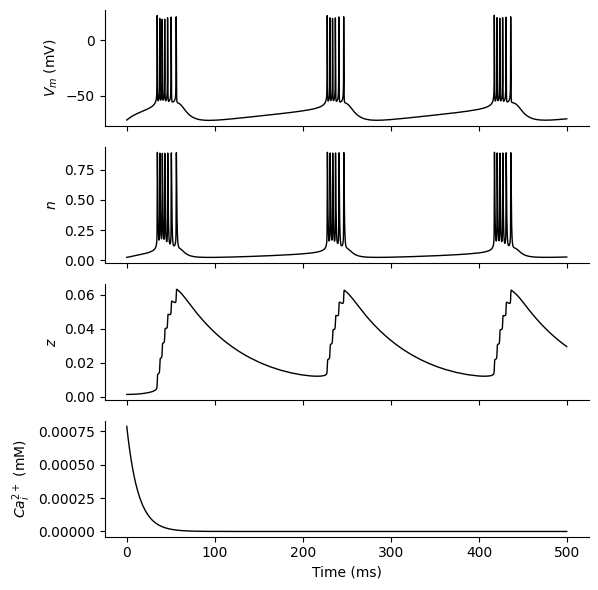

In [7]:
idx = t < 500
fig,ax = plt.subplots(4, 1, figsize=(6,6), sharex=True)
ax[0].plot(t[idx], Vm[idx], 'k', lw=1)
ax[1].plot(t[idx], n[idx], 'k', lw=1)
ax[2].plot(t[idx], z[idx], 'k', lw=1)
ax[3].plot(t[idx], Ca[idx], 'k', lw=1)
ax[0].set_ylabel(r'$V_m$ (mV)')
ax[1].set_ylabel(r'$n$')
ax[2].set_ylabel(r'$z$')
ax[3].set_ylabel(r'$Ca_i^{2+}$ (mM)')
ax[-1].set_xlabel('Time (ms)')
sns.despine()
fig.tight_layout()

In the paper, they perform a bifurcation analysis with 0 external calcium concentration, to show that the bursting dynamics are due to the interplay between fast variables ($V_m$ and the gating variables of the "fast" currents) and the slow variable $z$, the gating variable of the M-type K+ current, which acts as a "parameter" for the other fast variables.

The following is Fig. 5 of the paper, which illustrates these consideration in greater detail:
<img src="golomb_bif_diag.png" width=600px/>

Here we plot each of $V_m$, $n$ and $z$ versus each other, as a way of looking at how fast sodium spikes are superimposed to a slower-varying variable, thus leading to a burst of action potentials.

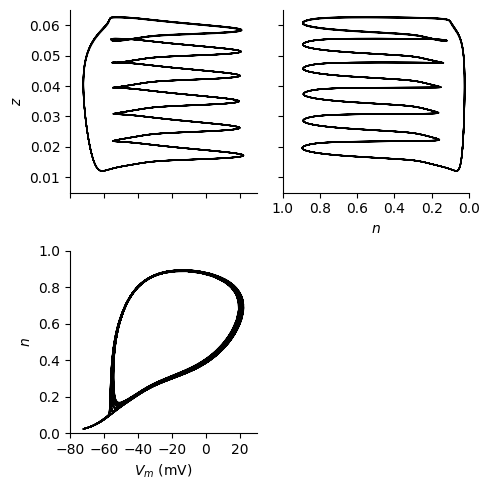

In [8]:
ttran = 500
limits = {'Vm': [-80,30], 'n': [0,1], 'z': [0.005,0.035]}
ticks = {'Vm': np.r_[-80:30:20], 'n': np.r_[0:1.1:0.2], 'z': np.r_[0.01 : 0.035 : 0.01]}
if zero_calcium:
    limits['z'][1] = 0.065
    ticks['z'] = np.r_[0.01 : 0.065 : 0.01]
idx = (t > ttran) & (t < ttran + 1000)
fig,ax = plt.subplots(2, 2, figsize=(5,5))

ax[0,0].plot(Vm[idx], z[idx], 'k', lw=1)
ax[0,0].set_xlim(limits['Vm'])
ax[0,0].set_xticks(ticks['Vm'])
ax[0,0].set_xticklabels([])
ax[0,0].set_ylim(limits['z'])
ax[0,0].set_yticks(ticks['z'])
ax[0,0].set_ylabel(r'$z$')

ax[0,1].plot(n[idx], z[idx], 'k', lw=1)
ax[0,1].set_xlim(np.flip(limits['n']))
ax[0,1].set_xticks(ticks['n'])
ax[0,1].set_xlabel(r'$n$')
ax[0,1].set_ylim(limits['z'])
ax[0,1].set_yticks(ticks['z'])
ax[0,1].set_yticklabels([])

ax[1,0].plot(Vm[idx], n[idx], 'k', lw=1)
ax[1,0].set_xlim(limits['Vm'])
ax[1,0].set_xticks(ticks['Vm'])
ax[1,0].set_xlabel(r'$V_m$ (mV)')
ax[1,0].set_ylim(limits['n'])
ax[1,0].set_yticks(ticks['n'])
ax[1,0].set_ylabel(r'$n$')

ax[1,1].set_visible(False)
sns.despine()
fig.tight_layout()